# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import missingno as msno

import warnings
warnings.filterwarnings('ignore')


# Import the dataset

In [2]:
data = pd.read_csv('diabetes-dataset.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


# Exploratory Data Analysis

In [3]:
data.shape

(2000, 9)

In [4]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
data.Outcome.value_counts()

Outcome
0    1316
1     684
Name: count, dtype: int64

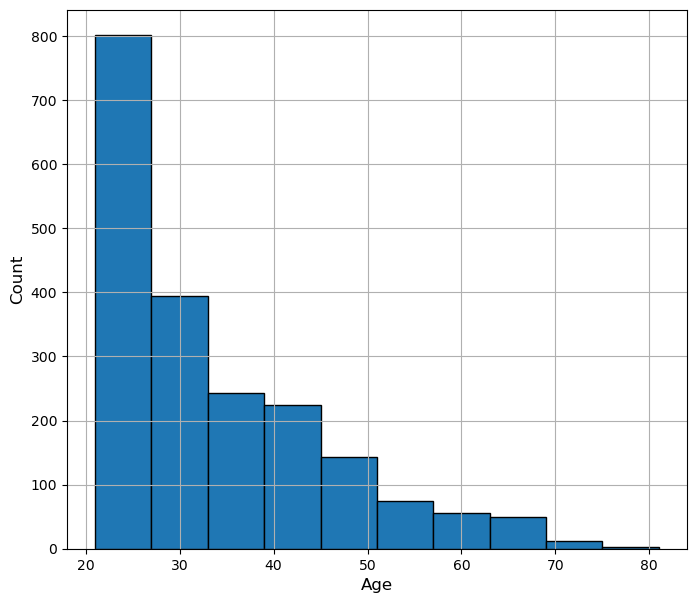

In [6]:
# Plot the histogram of the Age variable
plt.figure(figsize=(8,7))
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
data["Age"].hist(edgecolor = "black");

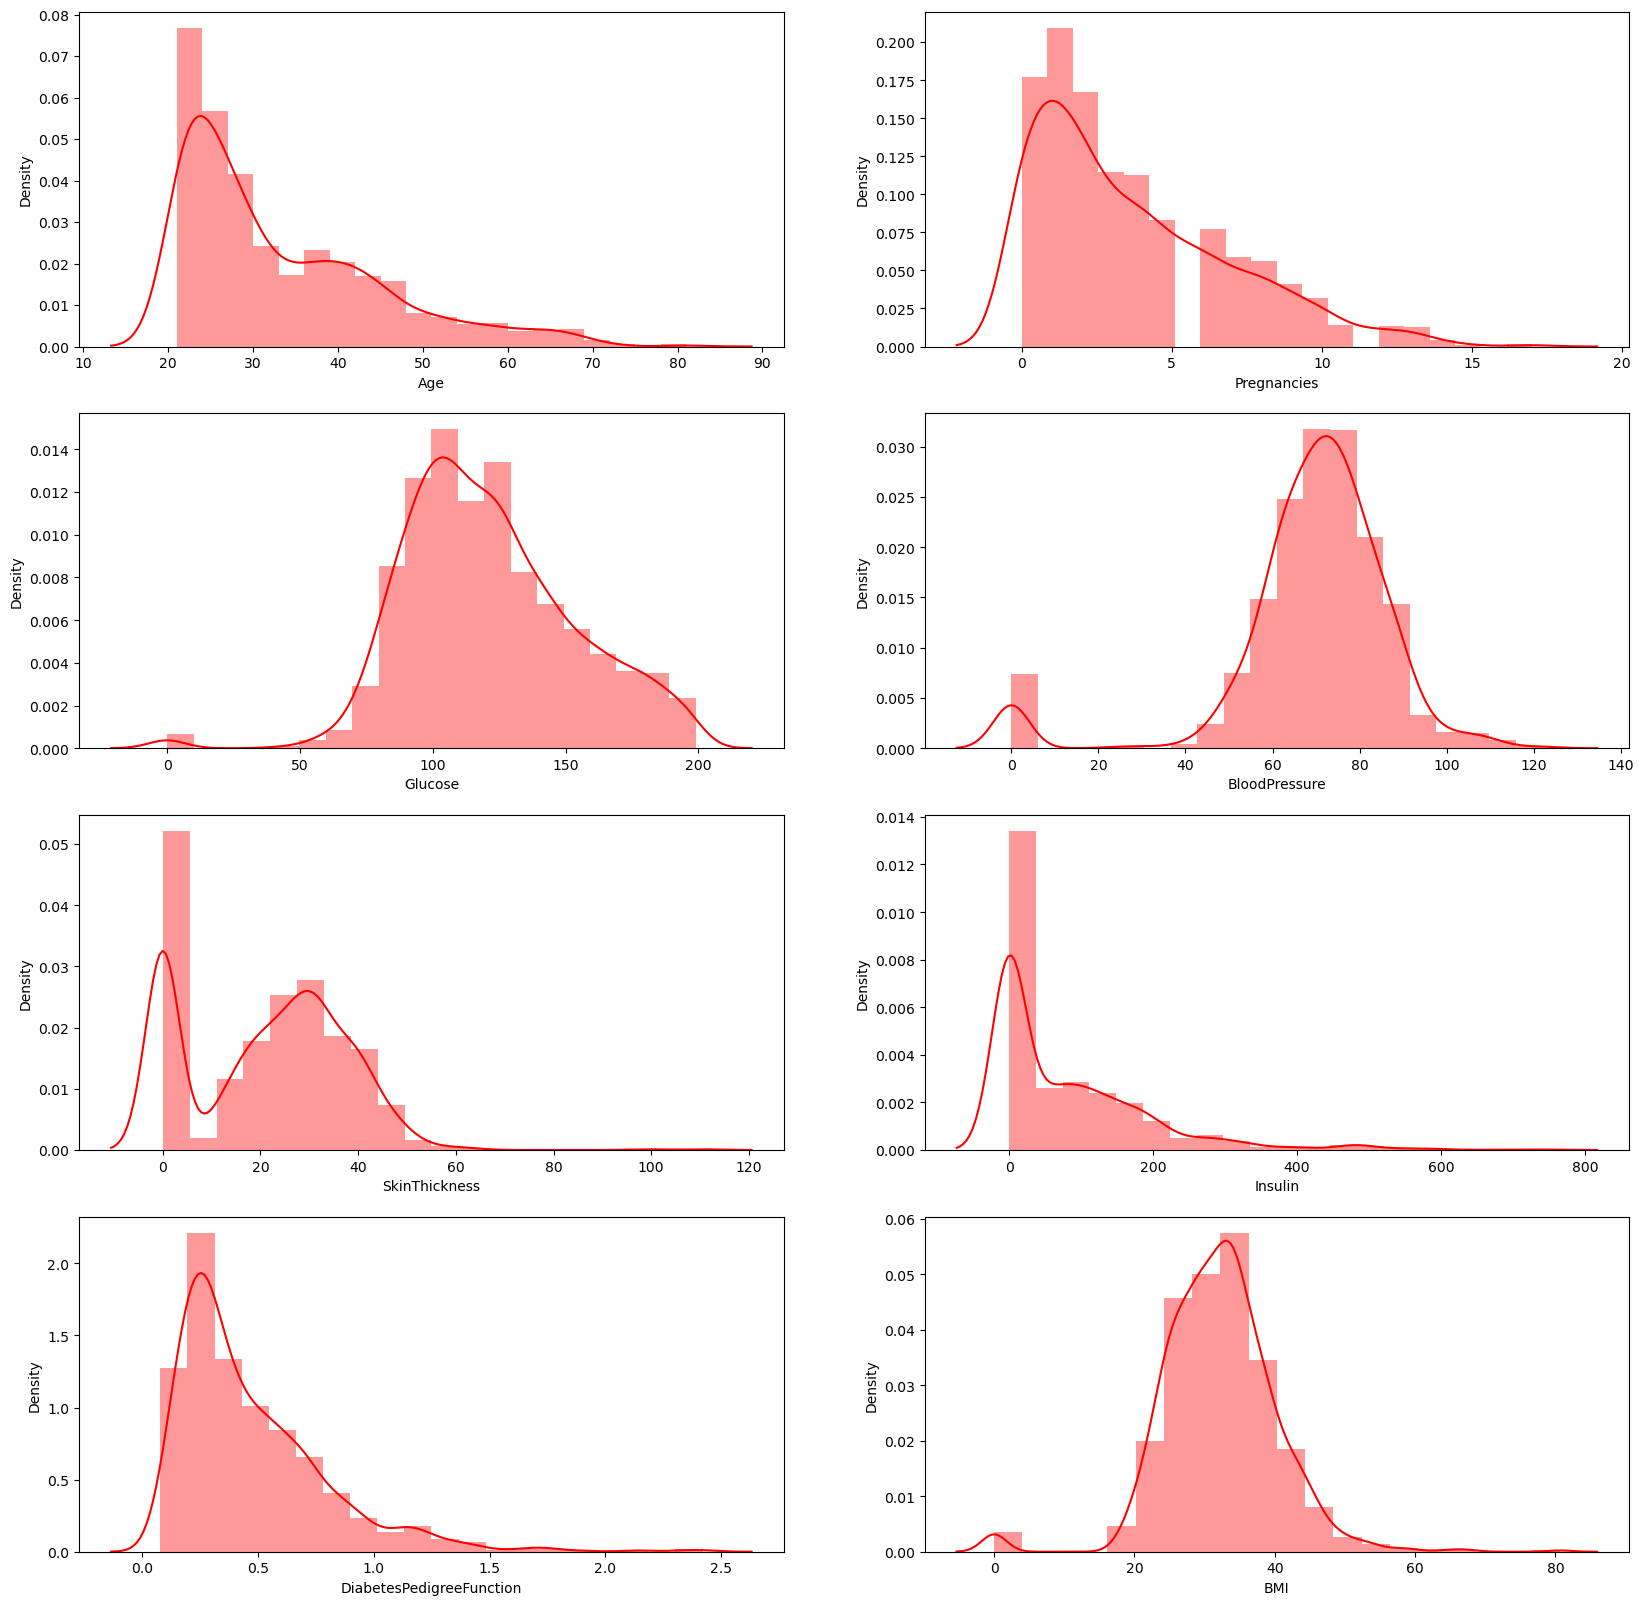

In [7]:
fig, ax = plt.subplots(4,2, figsize=(20,20))
sns.distplot(data.Age, bins = 20, ax=ax[0,0], color="red") 
sns.distplot(data.Pregnancies, bins = 20, ax=ax[0,1], color="red") 
sns.distplot(data.Glucose, bins = 20, ax=ax[1,0], color="red") 
sns.distplot(data.BloodPressure, bins = 20, ax=ax[1,1], color="red") 
sns.distplot(data.SkinThickness, bins = 20, ax=ax[2,0], color="red")
sns.distplot(data.Insulin, bins = 20, ax=ax[2,1], color="red")
sns.distplot(data.DiabetesPedigreeFunction, bins = 20, ax=ax[3,0], color="red") 
sns.distplot(data.BMI, bins = 20, ax=ax[3,1], color="red")
plt.show()

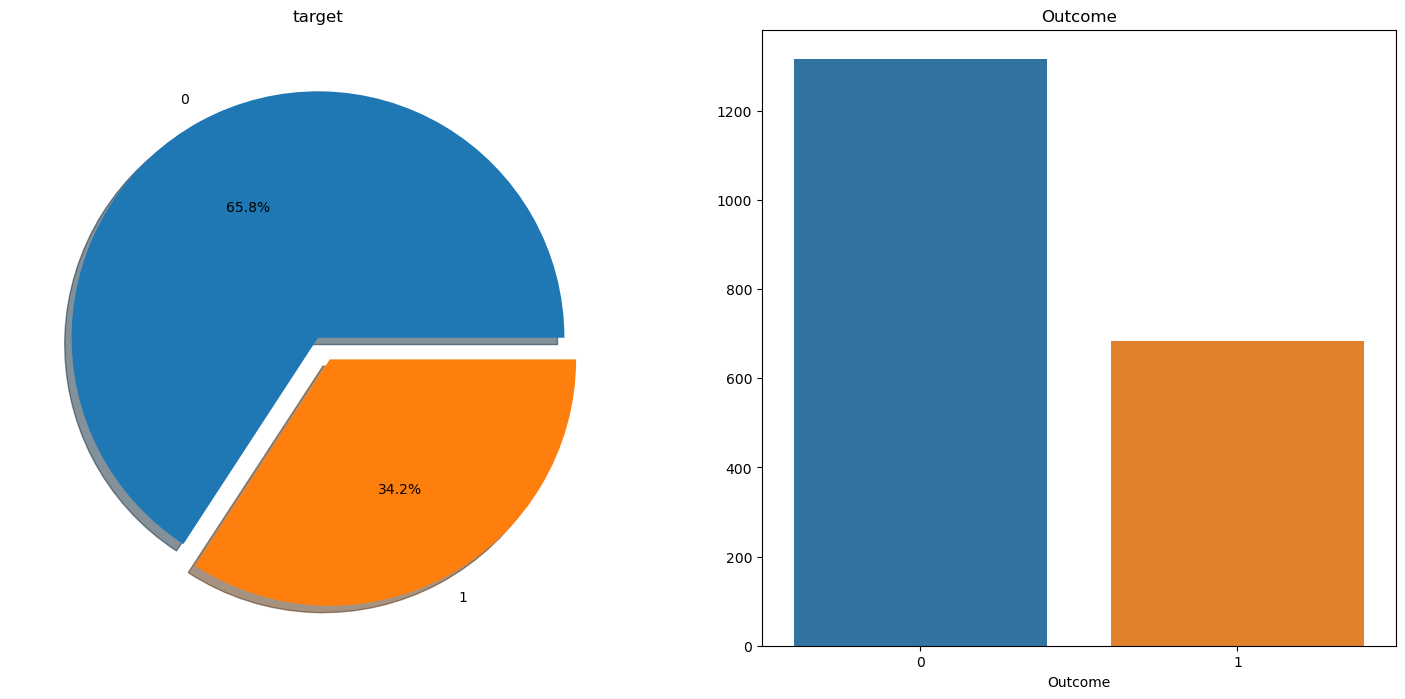

In [8]:
# Visualize the distribution of the outcome variable in the data -> 0 - Healthy, 1 - Diabetic
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Outcome'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot(x='Outcome', data=data, ax=ax[1])
ax[1].set_title('Outcome')
ax[1].set_ylabel('')
plt.show()

In [9]:
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.120405,0.149672,-0.063375,-0.076600,0.019475,-0.025453,0.539457,0.224437
Glucose,0.120405,1.000000,0.138044,0.062368,0.320371,0.226864,0.123243,0.254496,0.458421
BloodPressure,0.149672,0.138044,1.000000,0.198800,0.087384,0.281545,0.051331,0.238375,0.075958
SkinThickness,-0.063375,0.062368,0.198800,1.000000,0.448859,0.393760,0.178299,-0.111034,0.076040
Insulin,-0.076600,0.320371,0.087384,0.448859,1.000000,0.223012,0.192719,-0.085879,0.120924
BMI,0.019475,0.226864,0.281545,0.393760,0.223012,1.000000,0.125719,0.038987,0.276726
DiabetesPedigreeFunction,-0.025453,0.123243,0.051331,0.178299,0.192719,0.125719,1.000000,0.026569,0.155459
Age,0.539457,0.254496,0.238375,-0.111034,-0.085879,0.038987,0.026569,1.000000,0.236509
Outcome,0.224437,0.458421,0.075958,0.076040,0.120924,0.276726,0.155459,0.236509,1.000000


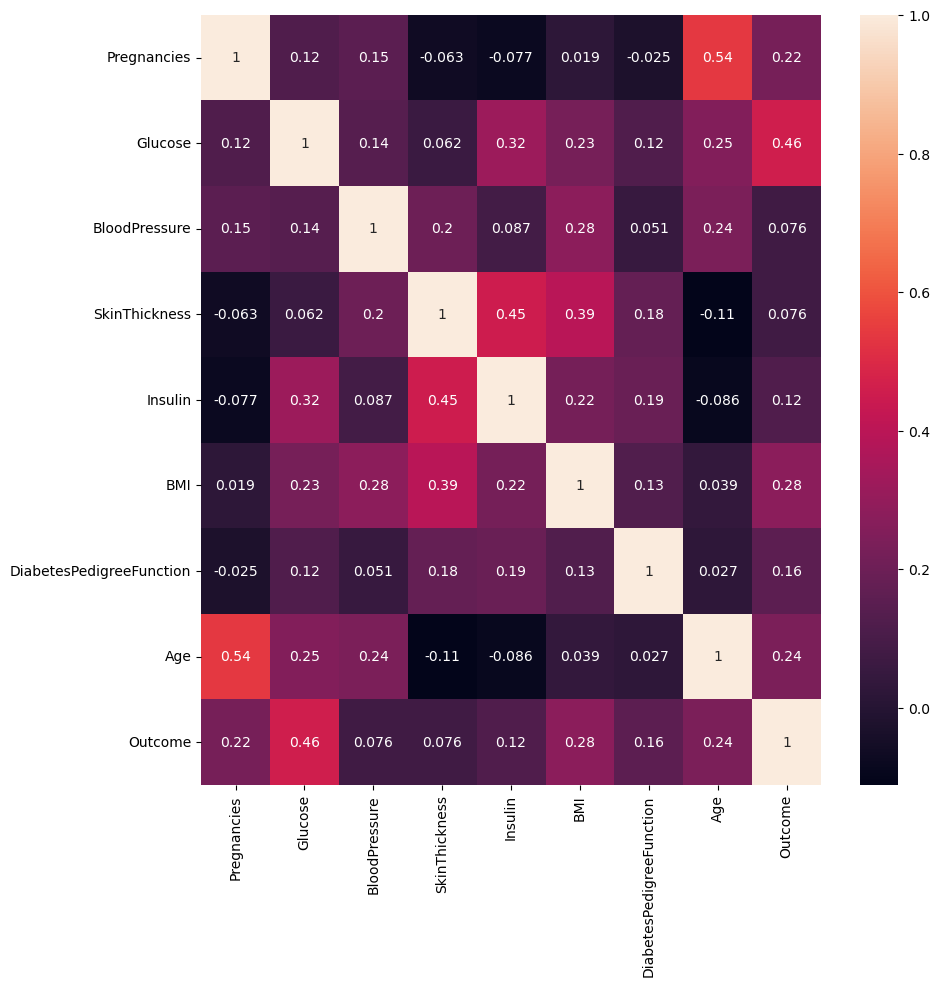

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot = True)
plt.show()

In [11]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [12]:
data.isnull().sum()

Pregnancies                   0
Glucose                      13
BloodPressure                90
SkinThickness               573
Insulin                     956
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<Axes: >

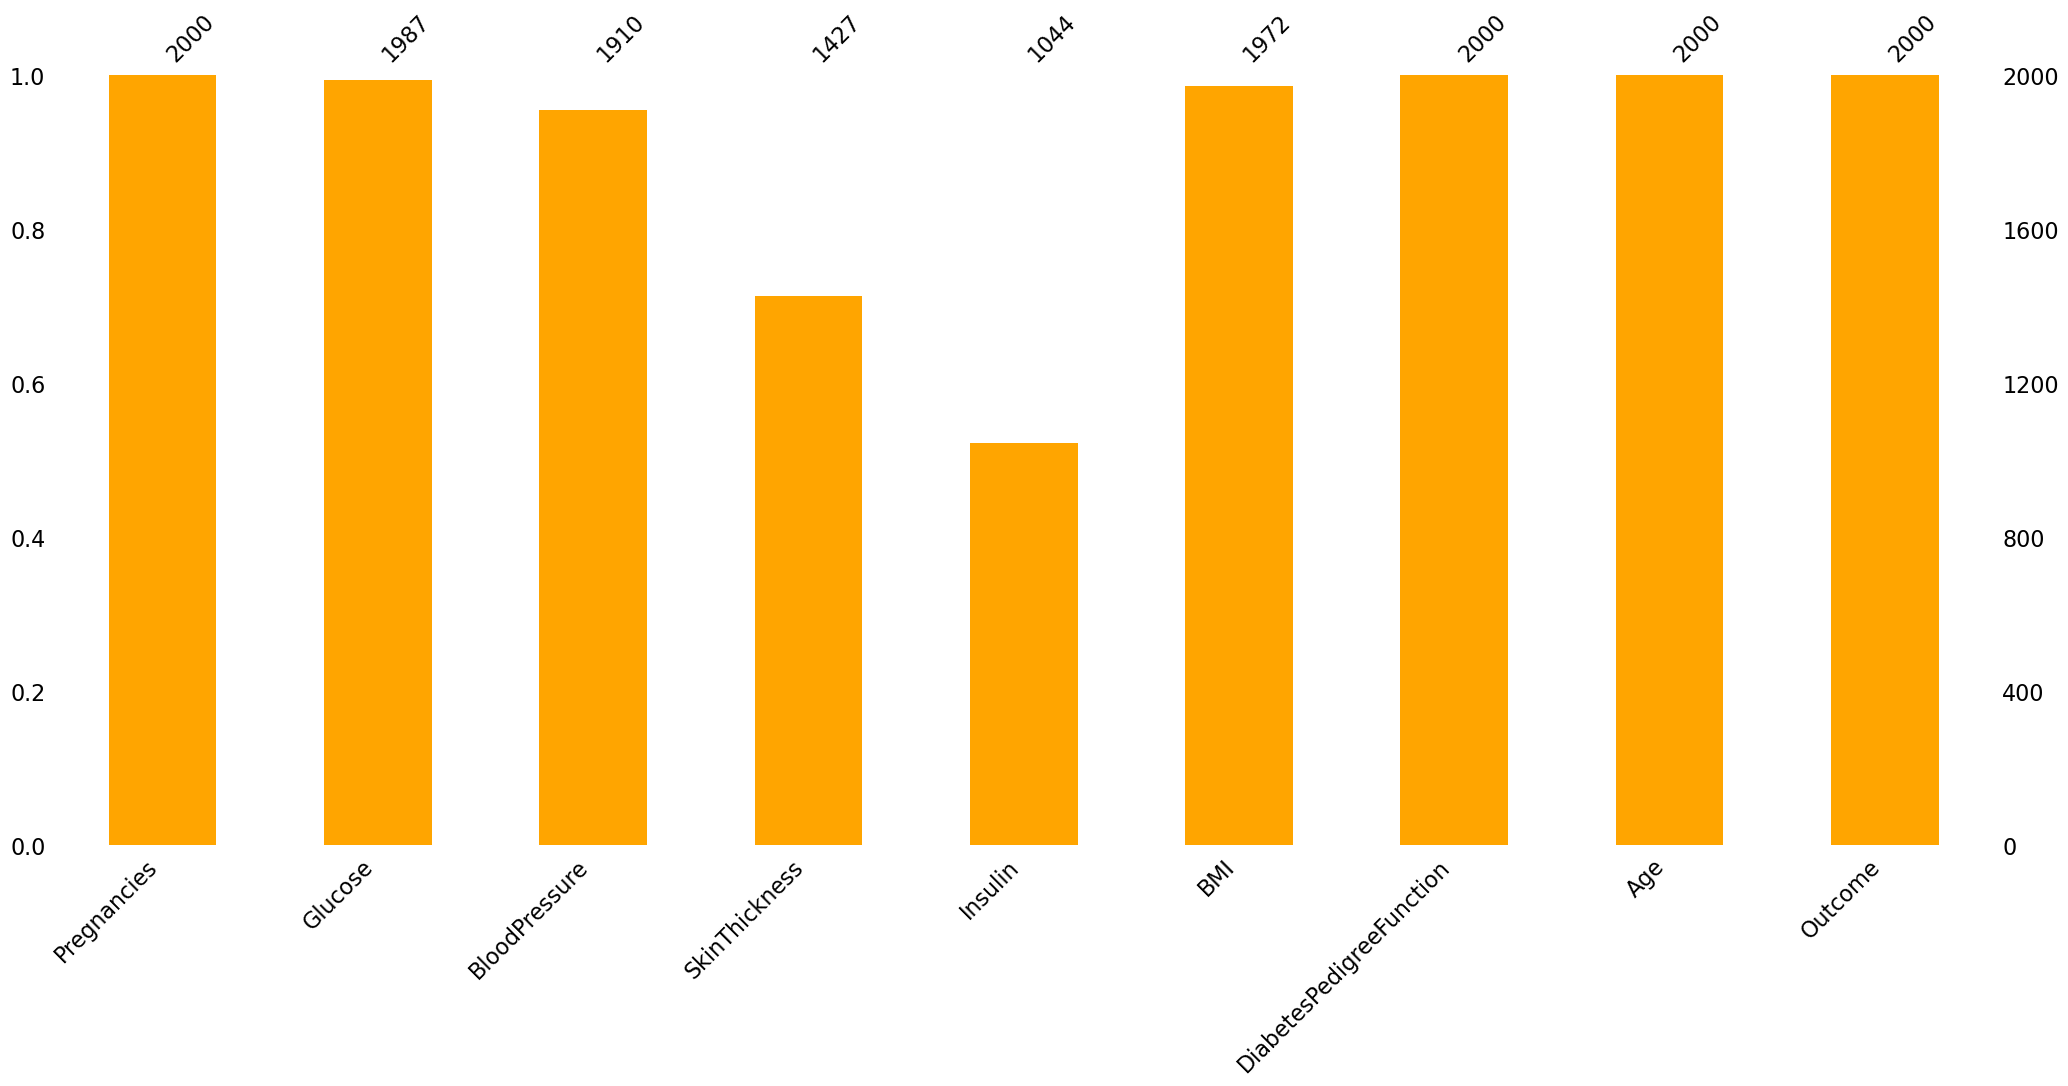

In [13]:
msno.bar(data, color="orange")

In [14]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [15]:
columns = data.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    data.loc[(data['Outcome'] == 0 ) & (data[i].isnull()), i] = median_target(i)[i][0]
    data.loc[(data['Outcome'] == 1 ) & (data[i].isnull()), i] = median_target(i)[i][1]

<Axes: >

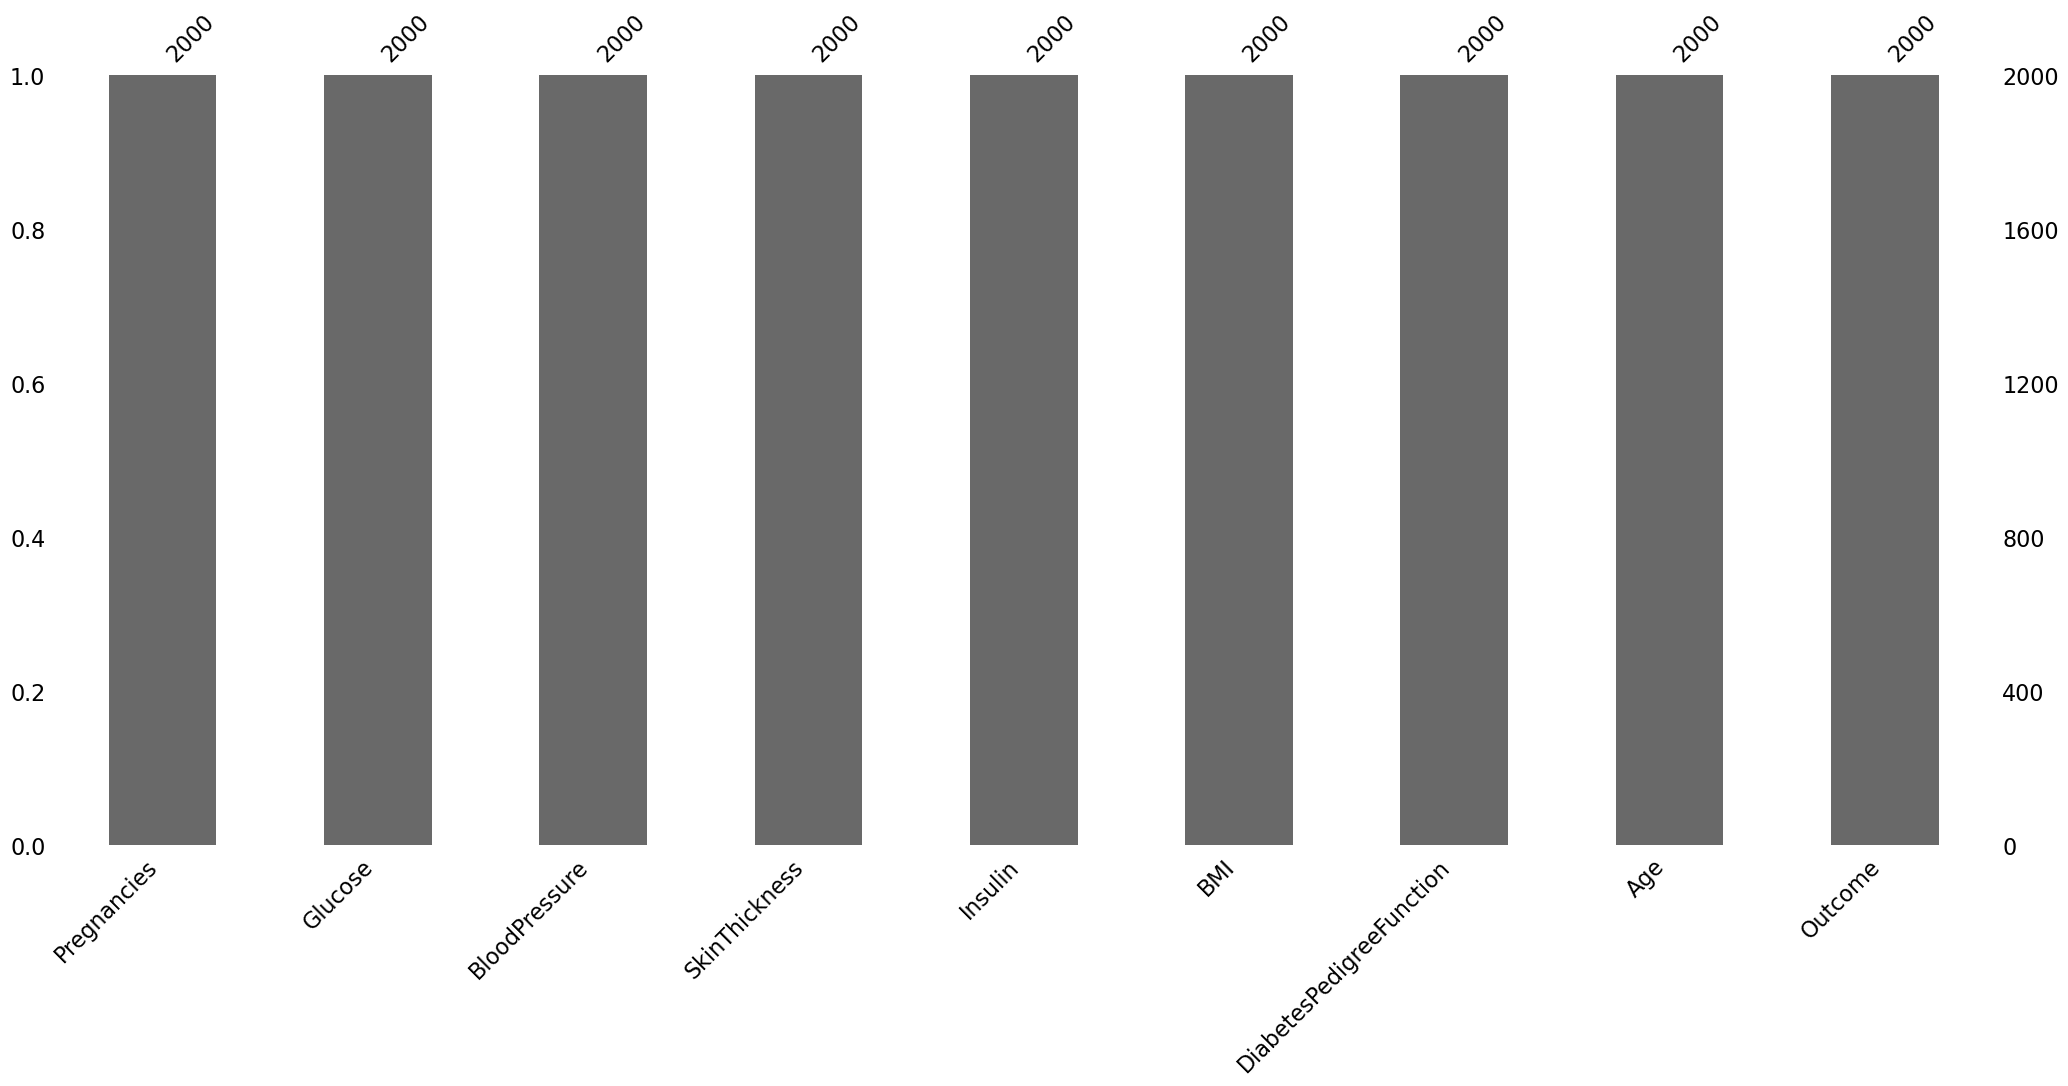

In [16]:
msno.bar(data)

# Model Building

In [17]:
X = data.iloc[:,:-1]
y = data['Outcome']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size = 0.2, random_state = 42)

In [19]:
print("Train Set: ", X_train.shape, y_train.shape)
print("Test Set: ", X_test.shape, y_test.shape)

Train Set:  (1600, 8) (1600,)
Test Set:  (400, 8) (400,)


In [20]:
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

In [21]:
print(accuracy_score(y_test, model.predict(X_test))*100)

100.0


# Prediction

In [22]:
input_data = (0,145,0,0,0,44.2,0.63,31)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = model.predict(input_data_reshaped)


if (prediction[0] == 0):
  print('The person is not diabetic')
else:
  print('The person is diabetic')

The person is not diabetic


# Pickling the model

In [23]:
filename = 'Diabetic_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [24]:
# loading the saved model
loaded_model = pickle.load(open('Diabetic_model.sav', 'rb'))